## Kinematic Bicycle Model

PID parameter tunning depends on the characteristics of system. And it is known that there's no 'one-size-fit-all' tunning method. For the project, i decided to go for a model-based auto-tunning using our python script of kinematic bicycle model, and modified it to write the auto-tunning script. 

In [61]:

import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        # theta = w = tan(delta) * speed / L
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)
    


def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0, 1, 0)
    robot.set_steering_drift(10 / 180 * np.pi)
    return robot

# run - does a single control run
# NOTE: We use params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n

## Goordinate Ascent auto-tunning

iter191 Final error = 0.5528806292269706, params=[0.2864386636430725, 0.0, 0.0]
iter1151 Final error = 0.37126759751677324, params=[0.2864386636430725, 3.0843418153144158, 0.0]
iter358 Final error = 1.1696428867847007e-07, params=[0.2864386636430725, 3.0843418153144158, 0.01033423736942282]


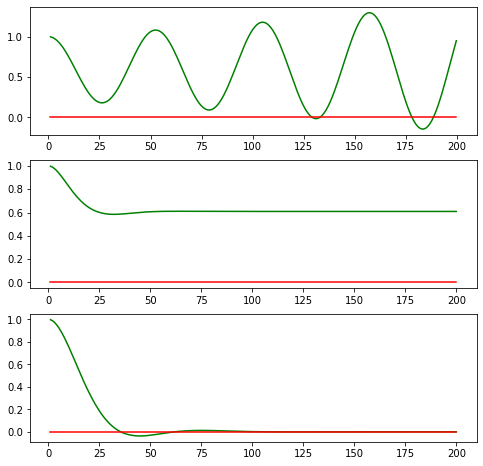

In [202]:
def twiddle(tol, p, dp, s): 

    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p,speed=s)

    it = 0
    while sum(dp) > tol:
        #print("Iter {}, berror = {}, params={}".format(it, best_err, p))
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p,speed=s)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p,speed=s)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return it,p,best_err




# Auto-tunning:
# Decide initial p value, the script spit out optimized p,i,d gain.
# Note the 2nd argument of tupple is speed for our kinematic model.

p, s = [0, 0, 0], 1
#p, s = [0, 0, 0], 2

tol = 0.00002

# optimize p with others fixed.
dp = [1, 0, 0]
it,params, err = twiddle(tol, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params))
robot = make_robot()
x_traj1, y_traj1, err = run(robot, params, speed=s)
init_p = params[0]

# optimize d with others fixed.
tol = 0.00002
p = [init_p, 0, 0]
dp = [0, 1, 0]
it,params, err = twiddle(tol, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params))
robot = make_robot()
x_traj2, y_traj2, err = run(robot, params, speed=s)
init_d = params[1]

# optimize i with others fixed.
tol = 0.00002
p = [init_p, init_d, 0]
dp = [0, 0, 1]
it,params, err = twiddle(tol, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params))
robot = make_robot()
x_traj3, y_traj3, err = run(robot, params, speed=s)
init_i = params[2]


n = len(x_traj1)
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(8, 8))
ax1.plot(x_traj1, y_traj1, 'g', label='Twiddle PID controller')
ax1.plot(x_traj1, np.zeros(n), 'r', label='reference')
ax2.plot(x_traj2, y_traj2, 'g', label='Twiddle PID controller')
ax2.plot(x_traj2, np.zeros(n), 'r', label='reference')
ax3.plot(x_traj3, y_traj3, 'g', label='Twiddle PID controller')
ax3.plot(x_traj3, np.zeros(n), 'r', label='reference')


#params=[0.2864386636430725, 3.0843418153144158, 0.01033423736942282]

### **Auto-tunning for curv at speed 1**

iter495 Final error = 3.0042262317874055e-10, params=[0.3063393801031459, 3.757411395133915, 0.00895626708915423]
let's run PID with learned parameter
iter0 Final error = 0.008213734142174724, params=[0.3063393801031459, 3.757411395133915, 0.00895626708915423]
let's run PID with learned parameter
iter0 Final error = 0.04391380163435384, params=[0.3063393801031459, 3.757411395133915, 0.00895626708915423]
let's run PID with learned parameter


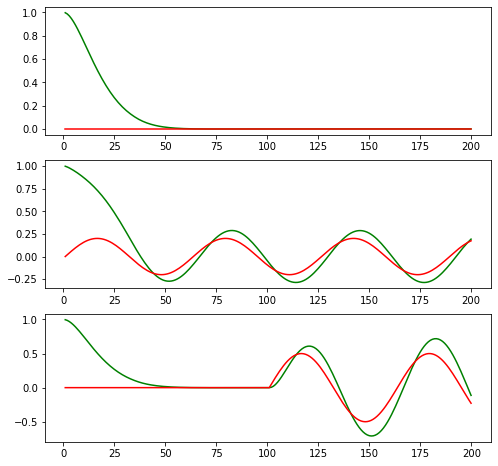

In [203]:
def run_curv(robot, params, y, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        #cte = robot.y
        #cte = y[i]-robot.y
        cte = robot.y-y[i]
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n

def twiddle_curv(tol, y, p, dp, s): 
    
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run_curv(robot, p,y, speed=s)

    # TODO: twiddle loop here
    it = 0
    while sum(dp) > tol:
        print("Iter {}, berror = {}, params={}".format(it, best_err, p))
        for i in range(3):
            p[i]+=dp[i] #try going uphill
            robot = make_robot()
            _,_,err = run_curv(robot, p,y, speed=s)
            if err < best_err: #error reduced?
                best_err = err #if succeed, keep it
                dp[i] *= 1.1   #inc d
            else:
                p[i] -= 2*dp[i] #if no, go opp. way
                robot = make_robot()
                _,_,err = run_curv(robot, p,y, speed=s)
                
                if err < best_err:#error reduced?
                    best_err = err
                    dp[i] *=1.1
                else:
                    p[i]+= dp[i] #if either way is not good, reduce scale.
                    dp[i] *= 0.9
        it+=1
    return it,p, best_err


#for speed =1
p, s = [0.28535166420074565, 3.072299626296505, 0.009462923496873782],1
#p, s =[2.058339659228449, 4.119454875695468, 0.14754626999666645], 2

dp = [1, 1, 1]
tol = 0.00002



it,params, err = twiddle(tol, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params))
print("let's run PID with learned parameter")
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params, speed=s)
init_p = params[0]

y_curv = 1/5*np.sin(1/10*np.arange(200))
it,params_curv, err = twiddle_curv(tol,y_curv, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params_curv))
print("let's run PID with learned parameter")
robot = make_robot()
x_trajectory2, y_trajectory2, err = run_curv(robot, params_curv, y_curv, speed=s)

y_comb = np.concatenate((np.zeros(100),1/2*np.sin(1/10*np.arange(100))), axis=0)
it,params_comb, err = twiddle_curv(tol,y_comb, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params_comb))
print("let's run PID with learned parameter")
robot = make_robot()
x_trajectory3, y_trajectory3, err = run_curv(robot, params_comb, y=y_comb, speed=s)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax2.plot(x_trajectory2, y_trajectory2, 'g', label='Twiddle PID controller')
ax2.plot(x_trajectory2, y_curv, 'r', label='reference')
ax3.plot(x_trajectory3, y_trajectory3, 'g', label='Twiddle PID controller')
ax3.plot(x_trajectory3, y_comb, 'r', label='reference')